In [3]:
! pip install -U langchain_community langchain-openai langchain langgraph bs4

In [4]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a code programming assistant, helping users perform operations related to Excel files. Ensure any code you provide can be executed \n
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Please ensure to use the latest OpenAI model, gpt-4o-mini.
  Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Data model
class code(BaseModel):
    """Code output"""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."

expt_llm = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
# question = "How do I build a RAG chain in LCEL?"
# solution = code_gen_chain.invoke({"context":concatenated_content,"messages":[("user",question)]})

In [6]:
# Test
question = "如何创建一个excel?"
solution = code_gen_chain.invoke(
    {"messages": [("user", question)]}
)
solution

code(prefix='该代码创建一个简单的Excel文件，包含姓名、年龄和城市的基本信息。', imports='import pandas as pd', code="import pandas as pd\n\n# 创建一个简单的Excel文件\n# 创建一些数据\ndata = {\n    '姓名': ['张三', '李四', '王五'],\n    '年龄': [25, 30, 22],\n    '城市': ['北京', '上海', '广州']\n}\n\n# 将数据转换为DataFrame\ndf = pd.DataFrame(data)\n\n# 将DataFrame输出到Excel文件\nfile_path = '人员信息.xlsx'\ndf.to_excel(file_path, index=False)\n\nprint(f'Excel文件已创建，保存路径为：{file_path}')", description='Schema for code solutions to questions about LCEL.')

In [7]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

In [8]:
from langchain_core.pydantic_v1 import BaseModel, Field

### Parameter

# Max tries
max_iterations = 3

### Nodes
def generate(state: GraphState):
    """
    Generate a code solution
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }



### Edges
def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

In [9]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)
app = workflow.compile()

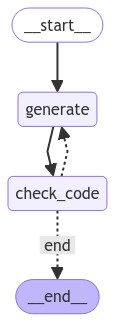

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
question = "将collect.xlsx文件以sheet页为文件名，单独保存成xlsx文件"
app.invoke({"messages": [("user", question)],"error": "","iterations": 0})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


{'error': 'no',
 'messages': [('user', '将collect.xlsx文件以sheet页为文件名，单独保存成xlsx文件'),
  ('assistant',
   "This code reads an Excel file named 'collect.xlsx', retrieves each sheet, and saves each sheet as a separate Excel file with the corresponding sheet name as the filename. \n Imports: import pandas as pd\nimport os \n Code: import pandas as pd\nimport os\n\n# Load the Excel file\nfile_path = 'collect.xlsx'\nexcel_file = pd.ExcelFile(file_path)\n\n# Iterate through each sheet and save it as a separate file\nfor sheet_name in excel_file.sheet_names:\n    # Define the new file name\n    new_file_name = f'{sheet_name}.xlsx'\n    \n    # Read the content of the sheet\n    sheet_data = pd.read_excel(file_path, sheet_name=sheet_name)\n    \n    # Save to a new Excel file\n    sheet_data.to_excel(new_file_name, index=False)")],
 'generation': code(prefix="This code reads an Excel file named 'collect.xlsx', retrieves each sheet, and saves each sheet as a separate Excel file with the correspondin